# CS441: Applied ML - HW 4

## Part I: Clustering and Fast Retrieval

Include all the code for Part 1 in this section

In [1]:
!apt install libomp-dev
!pip install faiss-cpu

'apt' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
# from google.colab import drive
# from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

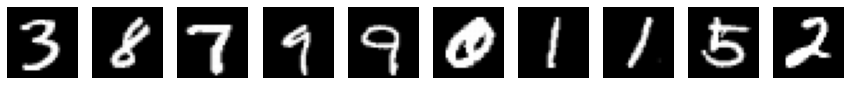

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [2]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [3]:
## Helper functions

# Returns the purity of the clustering according to labels, 
# and the label counts of each cluster
def get_purity(labels, cluster_idx):
  nclasses = int(max(labels)+1)
  nidx = int(max(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
  return purity, counts

# Returns an index list that can be used to re-order the counts according to 
# which label is most common 
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx 

###*Problem* 1.1 Clustering

For K=10, Purity=0.42304


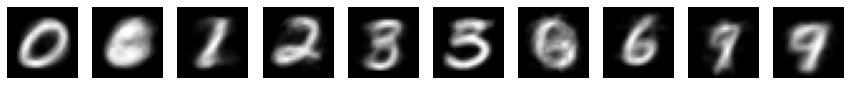

For K=10, Average Distance=42.70577621459961
For K=20, Purity=0.59508


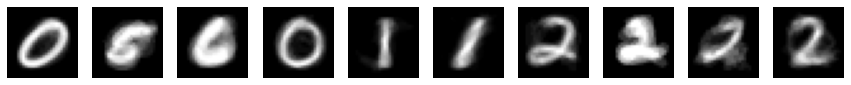

For K=20, Average Distance=39.53286361694336
For K=30, Purity=0.61526


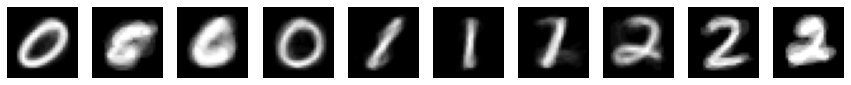

For K=30, Average Distance=38.135257720947266
For K=40, Purity=0.66386


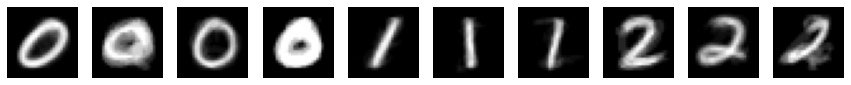

For K=40, Average Distance=37.39954376220703
For K=50, Purity=0.68308


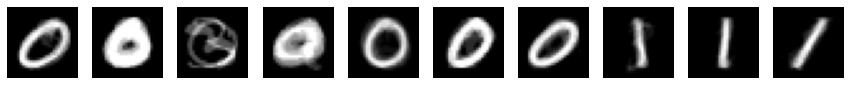

For K=50, Average Distance=36.681671142578125
For K=60, Purity=0.69734


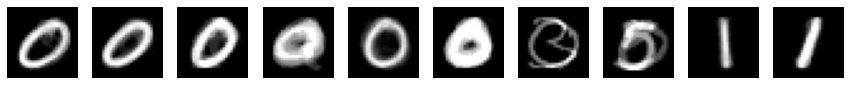

For K=60, Average Distance=36.5678596496582
For K=70, Purity=0.68842


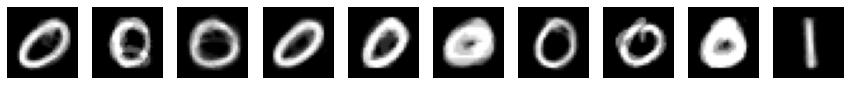

For K=70, Average Distance=36.20283889770508
For K=80, Purity=0.698


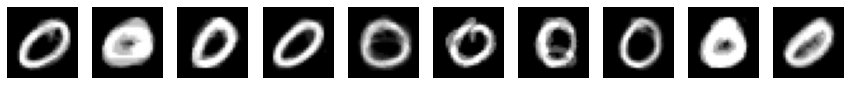

For K=80, Average Distance=36.040496826171875
For K=90, Purity=0.7251


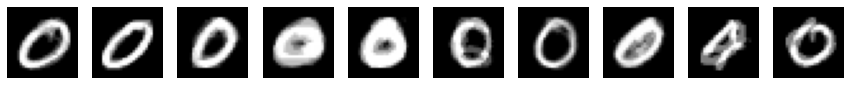

For K=90, Average Distance=35.788848876953125
For K=100, Purity=0.7467


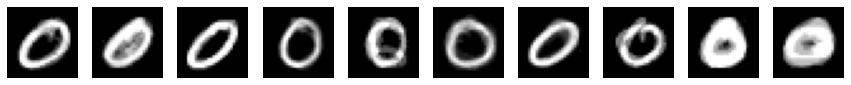

For K=100, Average Distance=35.6687126159668


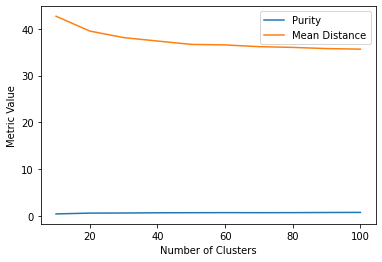

In [4]:
# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10, 20, 30,40,50,60,70,80,90, 100]

purity_k = []
mean_k = []

for K in clusters:
  # Initialize the k-means clustering object
  kmeans = faiss.Kmeans(dim, K, niter=20, verbose=True)

  # Train the k-means model
  kmeans.train(x_train[train_indices['s']])

  # Assign each data point to a cluster
  D, I = kmeans.index.search(x_train, 1)

  # Record and print Purity
  purity, counts = get_purity(y_train, I)
  purity_k.append(purity)
  print('For K={}, Purity={}'.format(K, purity))

  #Get Cluster indexes & Display the centroids
  idx = get_cluster_order(counts)
  centroids = kmeans.centroids[idx]
  display_mnist(centroids[:10], subplot_rows=1, subplot_cols=10)
    
  # Record and print Average Distance
  mean_dist = np.mean(D)
  mean_k.append(mean_dist)
  print('For K={}, Average Distance={}'.format(K, mean_dist))

#Plot K vs Purity and K vs Mean_Distances
plt.plot(clusters, purity_k, label='Purity')
plt.plot(clusters, mean_k, label='Mean Distance')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

### Problem 1.2 Fast Retrieval

In [5]:
## Brute Force (IndexFlatL2)

# set dimensions
dim = x_train.shape[1]

start_time = time.time()

# Initialize the index for Brute Force
index = faiss.IndexFlatL2(dim)
# Add Data & Print time to add
index.add(x_train)

add_time = time.time() - start_time
print('Time to add: {:.4f}s'.format(add_time))


# Perform Search and Compute Time required

k = 5
_, neighbors = index.search(x_test, k)

search_time = time.time() - start_time
print('Time to search: {:.4f}s'.format(search_time))
# Compute Test Error
test_err = 1 - np.mean([np.any(y_train[neighbors[i]] == y_test[i]) for i in range(len(y_test))])
print('Test error rate: {:.4f}'.format(test_err))




Time to add: 0.0951s
Time to search: 3.0599s
Test error rate: 0.0089


In [6]:
## LSH

# set dimensions
dim = x_train.shape[1]

start_time = time.time()
# Initialize the index for LSH
nbits = 8
quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexLSH(dim, nbits)
index.train(x_train[train_indices['s']])
index.add(x_train)


# Add Data & Print time to add

add_time = time.time() - start_time
print('Time to add: {:.4f}s'.format(add_time))

# Perform Search and Compute Time required
k = 5
_, neighbors = index.search(x_test, k)

search_time = time.time() - start_time
print('Time to search: {:.4f}s'.format(search_time))

# Compute Test Error

test_err = 1 - np.mean([np.any(y_train[neighbors[i]] == y_test[i]) for i in range(len(y_test))])
print('Test error rate: {:.4f}'.format(test_err))


Time to add: 0.1348s
Time to search: 0.3666s
Test error rate: 0.3943


## Part 2: Estimating PDFs

In [7]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
# from google.colab import drive
# from google.colab.patches import cv2_imshow
import cv2

# drive.mount('/content/drive')
# datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread('3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread('3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

In [8]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1 (Per-dimension discrete pdf)

In [14]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  # TO DO: 
  # (1) loop through values
  # (2) increment element of p corresponding to each value
  # (3) divide by sum of p    
  for i in range(x.shape[0]):
      p[int(x[i])] += 1
  p /= np.sum(p)
  return p

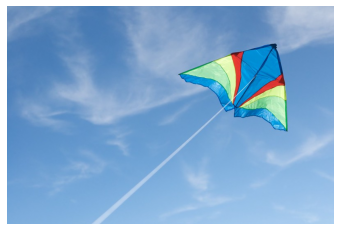

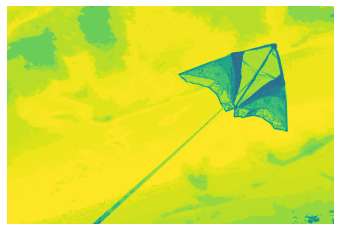

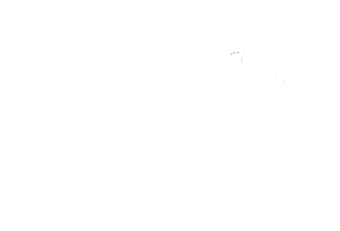

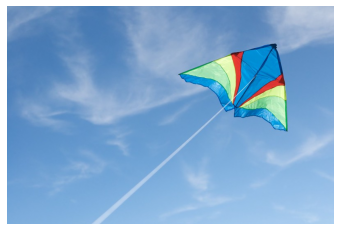

In [15]:
# set number of bins K
K = 16
# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum((im_pixels*K).astype(int), K-1)
# get pdf for each dimension using estimate_discrete_pdf
pdfs = [estimate_discrete_pdf(discrete_im_pixels[:, i], K) for i in range(3)]
# estimate score for each pixel in full image according to log pdfs
scores = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        scores[i, j] = np.sum([np.log(pdfs[k][discrete_im_pixels[i*im.shape[1]+j, k]]) for k in range(3)])

# display
display_score_maps(im, scores, -20)

#### Method 2 (K-means)

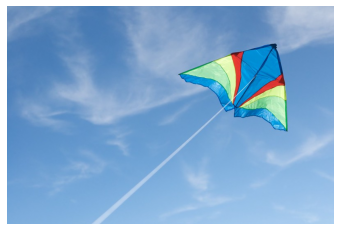

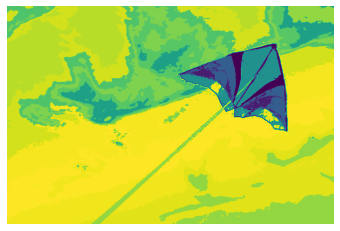

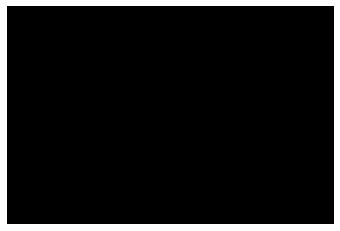

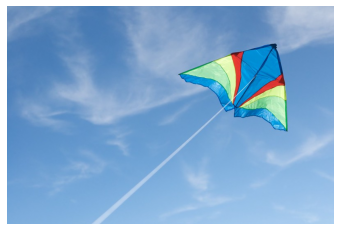

In [18]:
import faiss

# set K
K = 16
# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(3, K)
kmeans.train(im_pixels.astype(np.float32))
discrete_im_pixels = kmeans.index.search(im_pixels.astype(np.float32), 1)[1][:,0]
# get pdf over discrete values
pdf = estimate_discrete_pdf(discrete_im_pixels, K)
# estimate score for each pixel in full image according to log pdfs
scores = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        scores[i, j] = np.log(pdf[discrete_im_pixels[i*im.shape[1]+j]])
# display
display_score_maps(im, scores, -20)

#### Method 3 (GMM)

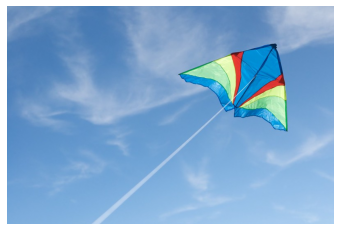

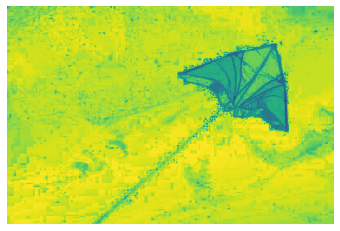

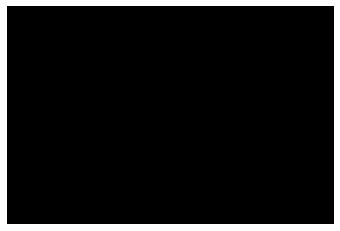

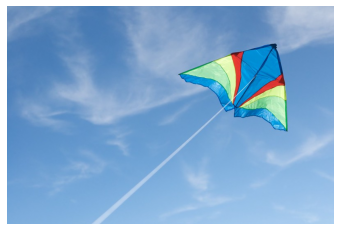

In [19]:
from sklearn.mixture import GaussianMixture

# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# get joint pdf using GMMs (choose number of components and other parameters)
gmm = GaussianMixture(n_components=10)
gmm.fit(im_pixels)
pdf = gmm.score_samples(im_pixels)
# estimate score for each pixel in full image according to log pdfs
scores = np.reshape(pdf, im.shape[:2])
# display
display_score_maps(im, scores, -20)

## Part 3: PCA and Data Compression

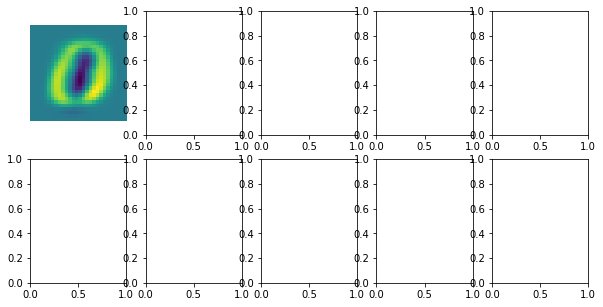

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components using x_train
pca = PCA()
pca.fit(x_train)
# Display First 10 Components
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(pca.components_[i].reshape(28, 28))
    ax.axis('off')
    plt.show()

c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


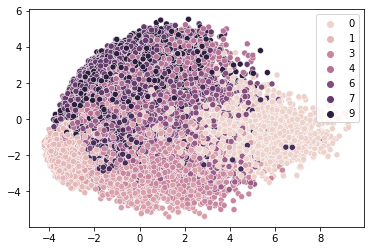

In [23]:
# Scatter plot of first two PCA dimensions
import seaborn as sns  #sns.scatterplot(x, y, hue=labels)

pca_2d = PCA(n_components=2)
x_train_pca_2d = pca_2d.fit_transform(x_train)
sns.scatterplot(x_train_pca_2d[:,0], x_train_pca_2d[:,1], hue=y_train)
plt.show();

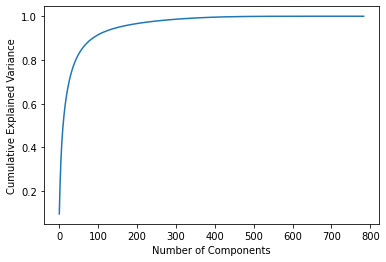

In [24]:
# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Number of components for 90% variance: 88


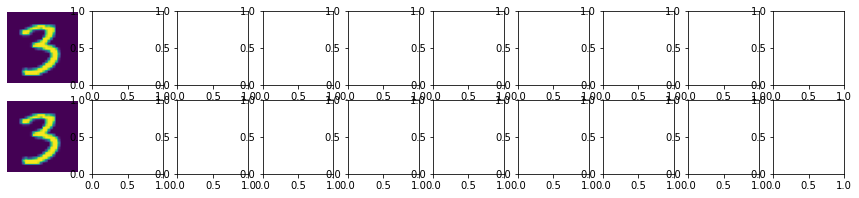

Time to add 50000 vectors to index: 50000 vectors, 2055.0575008392334 seconds
Time to search 10000 vectors in index: 2058.087319135666 seconds
Test error: 0.0331


In [38]:
# Select number of dimensions that explains 90% of variance, according to your plot above
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components for 90% variance: {n_components}")

# Display the first 10 samples before and after PCA compression
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    ax = axs[0, i]
    ax.imshow(x_train[i].reshape(28, 28))
    ax.axis('off')
    ax = axs[1, i]
    ax.imshow(pca.inverse_transform(pca.transform(x_train))[i].reshape(28, 28))
    ax.axis('off')
    plt.show()


# Initialize the index for Brute Force
index = faiss.IndexFlatL2(pca.transform(x_train).astype(np.float32).shape[1])

# Add Data & Print time to add
index.add(pca.transform(x_train).astype(np.float32))
print(f"Time to add {x_train.shape[0]} vectors to index: {index.ntotal} vectors, {time.time()-start_time} seconds")

# Perform Search and Compute Time required
k = 1
D, I = index.search(pca.transform(x_test).astype(np.float32), k)
print(f"Time to search {x_test.shape[0]} vectors in index: {time.time()-start_time} seconds")

# Compute Test Error
test_error = np.sum(y_test.reshape(-1) != y_train[I.reshape(-1)])
print(f"Test error: {test_error/x_test.shape[0]:.4f}")


## Part 4: Stretch Goals
Include all your code used for part 4 in this section. You can copy-paste code from parts 1, 2 or 3 if it is re-usable.

# Q4-P1

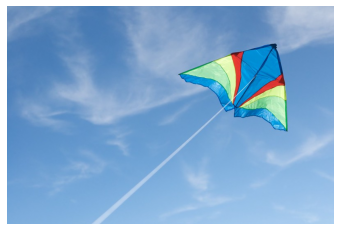

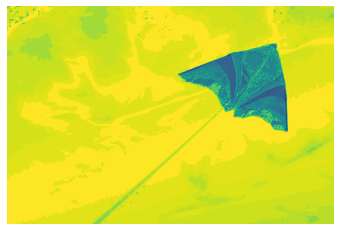

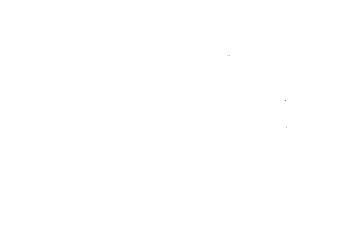

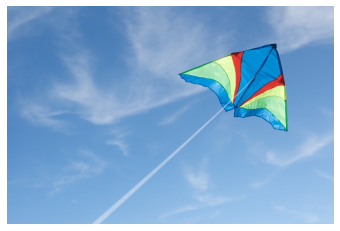

In [ ]:
# set number of bins K
K = 16
# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)

# center the data
im_pixels_centered = im_pixels - np.mean(im_pixels, axis=0)

# perform PCA
covariance = np.cov(im_pixels_centered.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance)
# sort eigenvectors in descending order of eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvectors = eigenvectors[:, idx]

# project data onto principal components
im_pixels_rotated = np.dot(im_pixels_centered, eigenvectors)

# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum((im_pixels_rotated*K).astype(int), K-1)

# get pdf for each dimension using estimate_discrete_pdf
pdfs = [estimate_discrete_pdf(discrete_im_pixels[:, i], K) for i in range(3)]

# estimate score for each pixel in full image according to log pdfs
scores = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        scores[i, j] = np.sum([np.log(pdfs[k][discrete_im_pixels[i*im.shape[1]+j, k]]) for k in range(3)])

# display
display_score_maps(im, scores, -20)


# P2

In [18]:
im = cv2.imread('Screenshot 2023-04-20 145102.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1

#### Method 1 (Per-dimension discrete pdf)

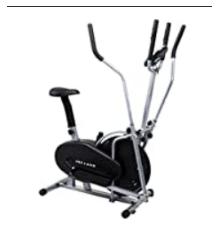

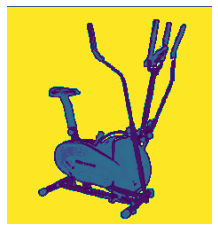

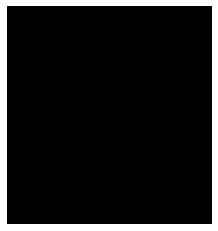

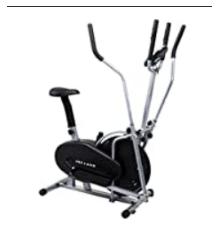

In [19]:
# set number of bins K
K = 16
# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum((im_pixels*K).astype(int), K-1)
# get pdf for each dimension using estimate_discrete_pdf
pdfs = [estimate_discrete_pdf(discrete_im_pixels[:, i], K) for i in range(3)]
# estimate score for each pixel in full image according to log pdfs
scores = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        scores[i, j] = np.sum([np.log(pdfs[k][discrete_im_pixels[i*im.shape[1]+j, k]]) for k in range(3)])

# display
display_score_maps(im, scores, -20)

#### Method 2 (K-means)

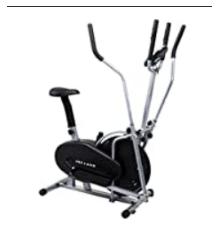

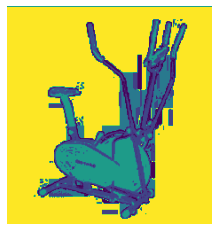

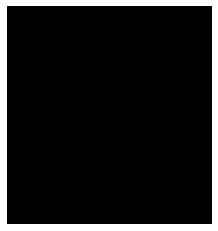

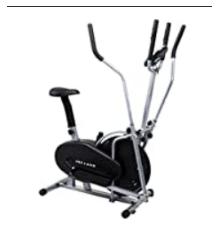

In [20]:
import faiss

# set K
K = 16
# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(3, K)
kmeans.train(im_pixels.astype(np.float32))
discrete_im_pixels = kmeans.index.search(im_pixels.astype(np.float32), 1)[1][:,0]
# get pdf over discrete values
pdf = estimate_discrete_pdf(discrete_im_pixels, K)
# estimate score for each pixel in full image according to log pdfs
scores = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        scores[i, j] = np.log(pdf[discrete_im_pixels[i*im.shape[1]+j]])
# display
display_score_maps(im, scores, -20)

#### Method 3 (GMM)

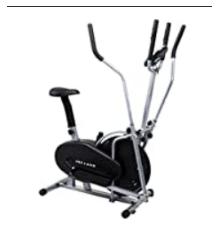

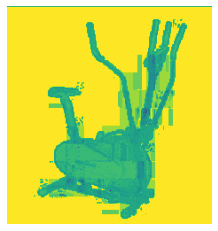

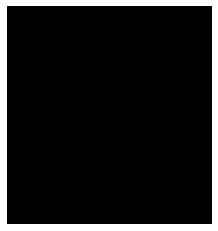

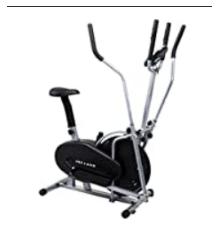

In [21]:
from sklearn.mixture import GaussianMixture

# reshape pixels to (h*w, 3)
im_pixels = im.reshape(-1, 3)
# get joint pdf using GMMs (choose number of components and other parameters)
gmm = GaussianMixture(n_components=10)
gmm.fit(im_pixels)
pdf = gmm.score_samples(im_pixels)
# estimate score for each pixel in full image according to log pdfs
scores = np.reshape(pdf, im.shape[:2])
# display
display_score_maps(im, scores, -20)

# P3

c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the onl

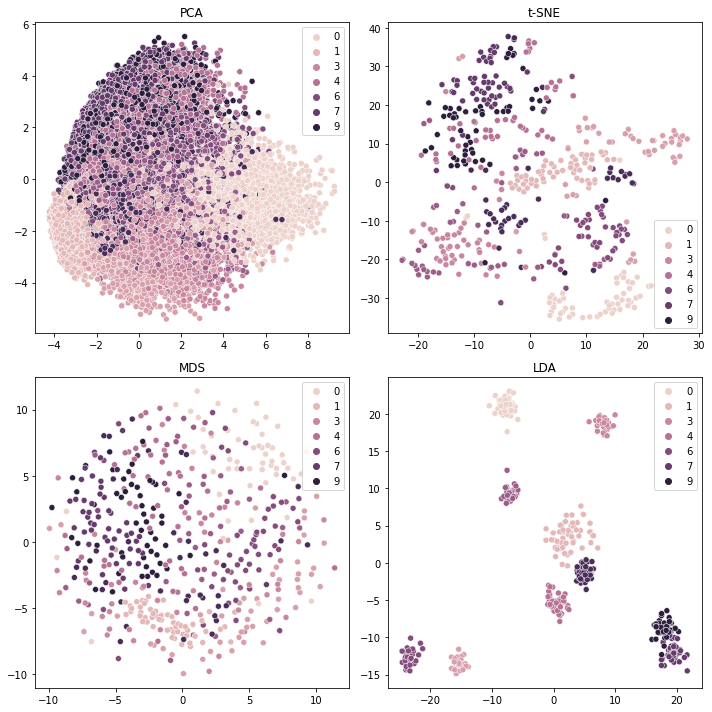

In [ ]:
# Import the required libraries
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Transform the data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train[train_indices['s']])

# Transform the data using MDS
mds = MDS(n_components=2, random_state=42)
x_train_mds = mds.fit_transform(x_train[train_indices['s']])

# Transform the data using LDA
lda = LDA(n_components=2)
x_train_lda = lda.fit_transform(x_train[train_indices['s']], y_train[train_indices['s']])

# Display the scatter plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot PCA scatterplot
sns.scatterplot(x_train_pca_2d[:,0], x_train_pca_2d[:,1], hue=y_train, ax=axs[0,0])
axs[0,0].set_title('PCA')

# Plot t-SNE scatterplot
sns.scatterplot(x_train_tsne[:,0], x_train_tsne[:,1], hue=y_train[train_indices['s']], ax=axs[0,1])
axs[0,1].set_title('t-SNE')

# Plot MDS scatterplot
sns.scatterplot(x_train_mds[:,0], x_train_mds[:,1], hue=y_train[train_indices['s']], ax=axs[1,0])
axs[1,0].set_title('MDS')

# Plot LDA scatterplot
sns.scatterplot(x_train_lda[:,0], x_train_lda[:,1], hue=y_train[train_indices['s']], ax=axs[1,1])
axs[1,1].set_title('LDA')

plt.tight_layout()
plt.show()